# Imports :

In [1]:
import numpy as np
import math
import scipy.io
import csv
from IPython.display import display
from scipy import sparse
import os.path
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from sklearn.feature_extraction.text import CountVectorizer
import re
from collections import Counter
from nltk.corpus import stopwords
import sklearn.neighbors, sklearn.linear_model, sklearn.ensemble, sklearn.naive_bayes
import time
import matplotlib.pyplot as plt
nltk.download("stopwords") 
nltk.download('punkt')
nltk.download('movie_reviews')
#removing stopwords
from nltk import word_tokenize,sent_tokenize

import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews


## drawing tools
# Load libraries

# Math
import numpy as np

# Visualization 
%matplotlib notebook 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage

# High-res visualization (but no rotation possible)
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png2x','pdf')

# Print output of LFR code
import subprocess

# Sparse matrix
import scipy.sparse
import scipy.sparse.linalg

# 3D visualization
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

# Import data
import scipy.io

# Import functions in lib folder
import sys
sys.path.insert(1, 'lib')

# Import helper functions
%load_ext autoreload
%autoreload 2

# Import distance function
import sklearn.metrics.pairwise

# Remove warnings
import warnings
warnings.filterwarnings("ignore")




def find_between_r( s, first, last ):
    try:
        start = s.rindex( first ) + len( first )
        end = s.rindex( last, start )
        return s[start:end]
    except ValueError:
        return ""

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading movie_reviews: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


# Datasets & Preprocessing

** Sentimental Analysis Text dataset: **

In [2]:
SAT_data =[]
with open('Projectdataset/Sentiment Analysis Dataset.csv', 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')#, quotechar='|')
    for row in spamreader:
        SAT_data.append(row) 
SAT_data = SAT_data[2:]
SAT_data = [[row[1],row[3]] for row in SAT_data]
SAT_data = np.array(SAT_data)
SAT_data[:,0] = [int(float(x))*5 for x in SAT_data[:,0]]
SAT_data_chunk = SAT_data[0:8000]
print('Length = {} '.format(len(SAT_data)))
print('Type = {}'.format(type(SAT_data)))
print(SAT_data[0:5])


Length = 1578613 
Type = <class 'numpy.ndarray'>
[['0' '                   I missed the New Moon trailer...']
 ['5' '              omg its already 7:30 :O']
 ['0'
  "          .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)..."]
 ['0' '         i think mi bf is cheating on me!!!       T_T']
 ['0' '         or i just worry too much?        ']]


** Polarity Data: **

In [4]:
polarity_data = []
file1 = open("Projectdataset/rt-polaritydata/rt-polarity.neg", "r")
file2 = open("Projectdataset/rt-polaritydata/rt-polarity.pos", "r")
dataneg = file1.readlines();
datapos = file2.readlines();
dataneg = [i.replace('\n','') for i in dataneg]
datapos = [i.replace('\n','') for i in datapos]

zero = np.zeros(len(dataneg))
dataneg = np.column_stack ((zero , dataneg) )

one = 5*np.ones(len(datapos))
datapos = np.column_stack ((one , datapos) )

polarity_data = np.concatenate ((datapos,dataneg), axis = 0)
np.random.shuffle(polarity_data)
polarity_data[:,0] = [int(float(x)) for x in polarity_data[:,0]]

print('Length = {} '.format(len(polarity_data)))
print('Type = {}'.format(type(polarity_data)))
print(polarity_data[0:5])

Length = 10662 
Type = <class 'numpy.ndarray'>
[['0' 'say this for the soundtrack , it drowns out the lousy dialogue . ']
 ['0'
  "mindless yet impressively lean spinoff of last summer's bloated effects fest the mummy returns . "]
 ['0'
  'you have no affinity for most of the characters . nothing about them is attractive . what they see in each other also is difficult to fathom . ']
 ['5'
  'an example of quiet , confident craftsmanship that tells a sweet , charming tale of intergalactic friendship . ']
 ['0'
  "the question hanging over the time machine is not , as the main character suggests , 'what if ? ' but rather , 'how can you charge money for this ? '"]]


** Amazon dataset: **

In [63]:
Amazon_data = []
file4 = open("Projectdataset/amazonMP3reviews/amazon_mp3", "r")
data4 = file4.read()

data4 = data4.split("#####")
for i in range(1,len(data4)):
    text = find_between_r( data4[i], "[fullText]:", "[rating]" )
    text = text.replace("\n",'')
    rating = find_between_r( data4[i],"[rating]:","[recommend]")
    Amazon_data.append([float(rating),text])
Amazon_data = np.asarray(Amazon_data)
Amazon_data_chunk = Amazon_data[0:8000]
Amazon_data[:,0] = [int(float(x)) for x in Amazon_data[:,0]]
print('Length = {} '.format(len(Amazon_data)))
print('Type = {}'.format(type(Amazon_data)))



Length = 31000 
Type = <class 'numpy.ndarray'>
31000


** TripAdvisor dataset **

In [7]:
tripAdvisor_data1 = []
path = 'Projectdataset/tripadvisor/Aspects'
dirs = os.listdir(path)


for direct in dirs:
    #print(direct)
    file5 = open(path+'/'+direct, "r")
    data5 = file5.read()
    data5 = data5.split("<Author>")
    data5 = data5[1:]
    for data in data5:
        ignore = False;
        text = find_between_r( data, "<Content>", "<Date>")
        text = text.replace("\n",'')
        rank = find_between_r( data, "<Rating>", "<Aspects>")
        rank = rank.rstrip().split('\t') 
        if (rank ==['']):
                ignore = True
        if not (ignore): 
            rank = [float(x) for x in rank]
            rank =round(np.mean(rank))
            tripAdvisor_data1.append((rank, text))
       
        
            


In [56]:
tripAdvisor_data2=np.asarray(tripAdvisor_data1[0:9000])
#tripAdvisor_data1=np.asarray(tripAdvisor_data1)
#tripAdvisor_data1 = [list(elem) for elem in tripAdvisor_data1]
tripAdvisor_data = [];
for row in tripAdvisor_data1:
    tripAdvisor_data.append([abs(int(row[0])), row[1]])

print('Length = {} '.format(len(tripAdvisor_data)))
print('Type = {}'.format(type(tripAdvisor_data)))

print(tripAdvisor_data[0:5])
print(type(tripAdvisor_data[0][0]))


Length = 198979 
Type = <class 'list'>
[[4, "Wonderful time- even with the snow! What a great experience! From the goldfish in the room (which my daughter loved) to the fact that the valet parking staff who put on my chains on for me it was fabulous. The staff was attentive and went above and beyond to make our stay enjoyable. Oh, and about the parking: the charge is about what you would pay at any garage or lot- and I bet they wouldn't help you out in the snow!  "], [4, "Lovely hotel, unique decor, friendly front desk staff, central location It's only recently that I've started staying at boutique hotels, so I'm definitely not an expert on the subtleties that these types of establishments provide. But I've already stayed at a few Kimptons and I must say that my experiences are mostly good. Hotel Monaco is no exception. The decor at the Kimpton Hotels is always unique - they have a wonderful way of pulling off colors, textures and patterns so one feels cool and trendy yet comfortable. 

** Sorted Data ACL **

In [6]:
#################################### Books ######################################################
books_data = []
file7 = open('Projectdataset/sorted_data_acl/books/negative.review', "r")
file8 = open('Projectdataset/sorted_data_acl/books/positive.review', "r")

negative = file7.read()
positive = file8.read()
######## books
negative = negative.split("<review>")
positive = positive.split("<review>")
negative = negative[1:]
positive = positive[1:]

a = []
b = []
for neg in negative:
    text = find_between_r( neg, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( neg, "<rating>", "</rating>")
    a.append((rate,text))
    
for pos in positive:
    text = find_between_r( pos, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( pos, "<rating>", "</rating>")
    b.append((rate,text))

books_data = np.concatenate((a,b) , axis = 0)
np.random.shuffle(books_data)
print("books review")
print('Length = {} '.format(len(books_data)))
print('Type = {}'.format(type(books_data)))
#print(books_data)

#################################### DVDs ######################################################
DVD_dataset= []
file9 = open('Projectdataset/sorted_data_acl/dvd/negative.review', "r")
file10 = open('Projectdataset/sorted_data_acl/dvd/positive.review', "r")
negative = file9.read()
positive = file10.read()

negative = negative.split("<review>")
positive = positive.split("<review>")
negative = negative[1:]
positive = positive[1:]

a = []
b = []
for neg in negative:
    text = find_between_r( neg, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( neg, "<rating>", "</rating>")
    a.append((rate,text))
    
for pos in positive:
    text = find_between_r( pos, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( pos, "<rating>", "</rating>")
    b.append((rate,text))


DVD_dataset = np.concatenate((a,b) , axis = 0)
np.random.shuffle(DVD_dataset)
print("dvds_review")
print('Length = {} '.format(len(DVD_dataset)))
print('Type = {}'.format(type(DVD_dataset)))
#print(DVD_dataset)

#################################### Electronics ######################################################
electronics_data = []
file11 = open('Projectdataset/sorted_data_acl/electronics/negative.review', "r")
file12 = open('Projectdataset/sorted_data_acl/electronics/positive.review', "r")

negative = file11.read()
positive = file12.read()

negative = negative.split("<review>")
positive = positive.split("<review>")
negative = negative[1:]
positive = positive[1:]

a = []
b = []
for neg in negative:
    text = find_between_r( neg, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( neg, "<rating>", "</rating>")
    a.append((rate,text))
    
for pos in positive:
    text = find_between_r( pos, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( pos, "<rating>", "</rating>")
    b.append((rate,text))

electronics_data = np.concatenate((a,b) , axis = 0)
np.random.shuffle(electronics_data)
print("electronics_review")
print('Length = {} '.format(len(electronics_data)))
print('Type = {}'.format(type(electronics_data)))
#print(electronics_data)
########################################## kitchen_&_housewares ##############################################
kh_dataset = []
file13 = open('Projectdataset/sorted_data_acl/kitchen_&_housewares/negative.review', "r")
file14 = open('Projectdataset/sorted_data_acl/kitchen_&_housewares/positive.review', "r")

negative = file13.read()
positive = file14.read()

negative = negative.split("<review>")
positive = positive.split("<review>")
negative = negative[1:]
positive = positive[1:]

a = []
b = []
for neg in negative:
    text = find_between_r( neg, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( neg, "<rating>", "</rating>")
    a.append((rate,text))
    
for pos in positive:
    text = find_between_r( pos, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( pos, "<rating>", "</rating>")
    b.append((rate,text))

kh_dataset = np.concatenate((a,b) , axis = 0)
np.random.shuffle(kh_dataset)
print("kh_review")
print('Length = {} '.format(len(kh_dataset)))
print('Type = {}'.format(type(kh_dataset)))

review_data = np.concatenate((books_data,DVD_dataset,electronics_data,kh_dataset))
np.random.shuffle(review_data)
print("review_data")
print('Length = {} '.format(len(review_data)))
print('Type = {}'.format(type(review_data)))
review_data[:,0] = [int(float(x)) for x in review_data[:,0]]
print(review_data[0:5])

books review
Length = 2000 
Type = <class 'numpy.ndarray'>
dvds_review
Length = 2000 
Type = <class 'numpy.ndarray'>
electronics_review
Length = 2000 
Type = <class 'numpy.ndarray'>
kh_review
Length = 2000 
Type = <class 'numpy.ndarray'>
review_data
Length = 8000 
Type = <class 'numpy.ndarray'>
[['1'
  "The is by far the weakest Grisham novel I've ever read.  The first two hundred pages creep along at a glacial pace as the protagonist (Joel Backman; more about him later) wanders Italy for nearly 200 pages, learning to speak the language and spending way too much time sipping espresso in quaint trattorias with Italian carictatures that would make Chico Marx cringe.  When Grisham finally rachets up the action and suspense, it's all for naught, as the story eventually limps and staggers to a completely listless and anticlimactic ending.As for Joel Backman, I can't think of a more unlikeable and unsympathetic protagonist in recent memory.  A disgraced lawyer, lobbyist and traitor that plow

# Naive Bayes Classification
This classifier is only used when we have binary classification. Here we applied it just as a trial.

In [13]:
def word_feats(words):
        return dict([(word, True) for word in words])
    
negids = movie_reviews.fileids('neg')
posids = movie_reviews.fileids('pos')
 
negfeats = [(word_feats(movie_reviews.words(fileids=[f])), 'neg') for f in negids]
posfeats = [(word_feats(movie_reviews.words(fileids=[f])), 'pos') for f in posids]

negcutoff = int(len(negfeats)*3/4)
poscutoff = int(len(posfeats)*3/4)

trainfeats = negfeats[:negcutoff] + posfeats[:poscutoff]
testfeats = negfeats[negcutoff:] + posfeats[poscutoff:]
print('train on %d instances, test on %d instances' % (len(trainfeats), len(testfeats)))
 
classifier = NaiveBayesClassifier.train(trainfeats)
print('accuracy:', nltk.classify.util.accuracy(classifier, testfeats))
classifier.show_most_informative_features()

train on 1500 instances, test on 500 instances
accuracy: 0.728
Most Informative Features
             magnificent = True              pos : neg    =     15.0 : 1.0
             outstanding = True              pos : neg    =     13.6 : 1.0
               insulting = True              neg : pos    =     13.0 : 1.0
              vulnerable = True              pos : neg    =     12.3 : 1.0
               ludicrous = True              neg : pos    =     11.8 : 1.0
                  avoids = True              pos : neg    =     11.7 : 1.0
             uninvolving = True              neg : pos    =     11.7 : 1.0
             fascination = True              pos : neg    =     10.3 : 1.0
              astounding = True              pos : neg    =     10.3 : 1.0
                 idiotic = True              neg : pos    =      9.8 : 1.0


# Feature Extraction
** Bag of Words Feature Extraction ** 






In [9]:
def column(matrix, i):
    return [row[i] for row in matrix]
def compute_bag_of_words(text, nwords):
    vectorizer = CountVectorizer(max_features=nwords)
    vectors = vectorizer.fit_transform(text)
    vocabulary = vectorizer.get_feature_names()
    return vectors, vocabulary

nwords = 300 # number of words to represent text

# all datasets texts
text_polarity = column(polarity_data,1)
text_amazon = column(Amazon_data_chunk,1)
text_sat = column(SAT_data_chunk,1)
text_trip = column(tripAdvisor_data2,1)
text_items = column(review_data,1)
# all datasets ratings
Y_polarity = np.asarray(column(polarity_data,0))
Y_amazon = np.asarray(column(Amazon_data_chunk,0))
Y_sat = np.asarray(column(SAT_data_chunk,0))
Y_trip = np.asarray(column(tripAdvisor_data2,0))
Y_items = np.asarray(column(review_data,0))

names = ["Polarity Dataset","Amazon Dataset","SAT dataset","Trip Advisor","Items"]
texts = [text_polarity,text_amazon,text_sat,text_trip,text_items]
Ys = [Y_polarity , Y_amazon, Y_sat, Y_trip, Y_items]
stop_words = set(stopwords.words('english'))

filtered_data =[]
bows = []
i = 0

for textset in texts:
    filtered=[];
    for item in textset:
        words = word_tokenize(item)
        words =[word.lower() for word in words]
        filtered_item=[];
        for w in words:
            if w not in stop_words:
                filtered_item.append(w)
        result = ' '.join(filtered_item)
        filtered.append(result)
    bow, vocab = compute_bag_of_words(filtered, nwords)
    bows.append(bow)
    print("Dataset ={}".format(names[i]))
    print("Length = {}".format(len(filtered))) 
    print("bow = {}".format(bow.shape))
    print("Y = {}".format(Ys[i].shape))
    filtered_data.append(filtered)
    i += 1


Dataset =Polarity Dataset
Length = 10662
bow = (10662, 300)
Y = (10662,)
Dataset =Amazon Dataset
Length = 8000
bow = (8000, 300)
Y = (8000,)
Dataset =SAT dataset
Length = 8000
bow = (8000, 300)
Y = (8000,)
Dataset =Trip Advisor
Length = 9000
bow = (9000, 300)
Y = (9000,)
Dataset =Items
Length = 8000
bow = (8000, 300)
Y = (8000,)


# Dividing into Training data and Testing data

In [10]:

X_trains = []
X_tests = []
Y_trains = []
Y_tests = []
i = 0
for textset in texts:
    cutoff = math.ceil(len(Ys[i])*0.75)
    print(cutoff)
    X_trains.append(bows[i][0:cutoff])
    X_tests.append(bows[i][cutoff:])
    Y_trains.append(Ys[i][0:cutoff])
    Y_tests.append(Ys[i][cutoff:])
    i+=1


7997
6000
6000
6750
6000


# Classifiers and using the right one

In [11]:

# The different classifiers
clf, train_accuracy, test_accuracy, exec_time = [], [], [], []
clf.append(sklearn.neighbors.KNeighborsClassifier()) # k-NN classifier
clf.append(sklearn.svm.LinearSVC()) # linear SVM classifier
clf.append(sklearn.linear_model.LogisticRegression()) # logistic classifier
clf.append(sklearn.ensemble.RandomForestClassifier())
clf.append(sklearn.linear_model.RidgeClassifier())
clf.append(sklearn.naive_bayes.BernoulliNB())
clf.append(sklearn.naive_bayes.MultinomialNB())


train_accuracies = []
test_accuracies = []


# train on different datasets 
for i in range (0,len(names)):
    print("Dataset = {}".format(names[i]))
    classifier = ['KNN','SVM','Log-R','RanF', 'RC','B','MultiNB']
    j = 0
    train_accuracy = []
    test_accuracy = []
    for c in clf:
        #t_start = time.process_time()
        c.fit(X_trains[i], Y_trains[i])
        train_pred = c.predict(X_trains[i])
        test_pred = c.predict(X_tests[i])
        train_accuracy .append( '{:5.2f}'.format(100*sklearn.metrics.accuracy_score(Y_trains[i], train_pred)) )
        test_accuracy .append( '{:5.2f}'.format(100*sklearn.metrics.accuracy_score(Y_tests[i], test_pred)) )
        #exec_time.append('{:5.2f}'.format(time.process_time() - t_start))
        print('Classifier:          {}'.format(classifier[j]))
        print('Train accuracy:      {}'.format(train_accuracy[j]))
        print('Test accuracy:       {}'.format(test_accuracy[j]))
        j+=1
        #print('Execution time:      {}'.format(exec_time))
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

Dataset = Polarity Dataset
Classifier:          KNN
Train accuracy:      72.30
Test accuracy:       59.44
Classifier:          SVM
Train accuracy:      67.94
Test accuracy:       66.60
Classifier:          Log-R
Train accuracy:      67.85
Test accuracy:       66.53
Classifier:          RanF
Train accuracy:      91.73
Test accuracy:       62.48
Classifier:          RC
Train accuracy:      67.99
Test accuracy:       66.64
Classifier:          B
Train accuracy:      67.46
Test accuracy:       66.75
Classifier:          MultiNB
Train accuracy:      67.38
Test accuracy:       66.53
Dataset = Amazon Dataset
Classifier:          KNN
Train accuracy:      60.75
Test accuracy:       42.90
Classifier:          SVM
Train accuracy:      60.47
Test accuracy:       54.75
Classifier:          Log-R
Train accuracy:      60.85
Test accuracy:       54.20
Classifier:          RanF
Train accuracy:      98.75
Test accuracy:       47.15
Classifier:          RC
Train accuracy:      56.73
Test accuracy:       

'Dataset: Polarity Dataset '

'best test accuracy = 66.75  for = B'

'Dataset: Amazon Dataset '

'best test accuracy = 54.75  for = SVM'

'Dataset: SAT dataset '

'best test accuracy = 70.10  for = MultiNB'

'Dataset: Trip Advisor '

'best test accuracy = 28.40  for = RC'

'Dataset: Items '

'best test accuracy = 52.05  for = MultiNB'

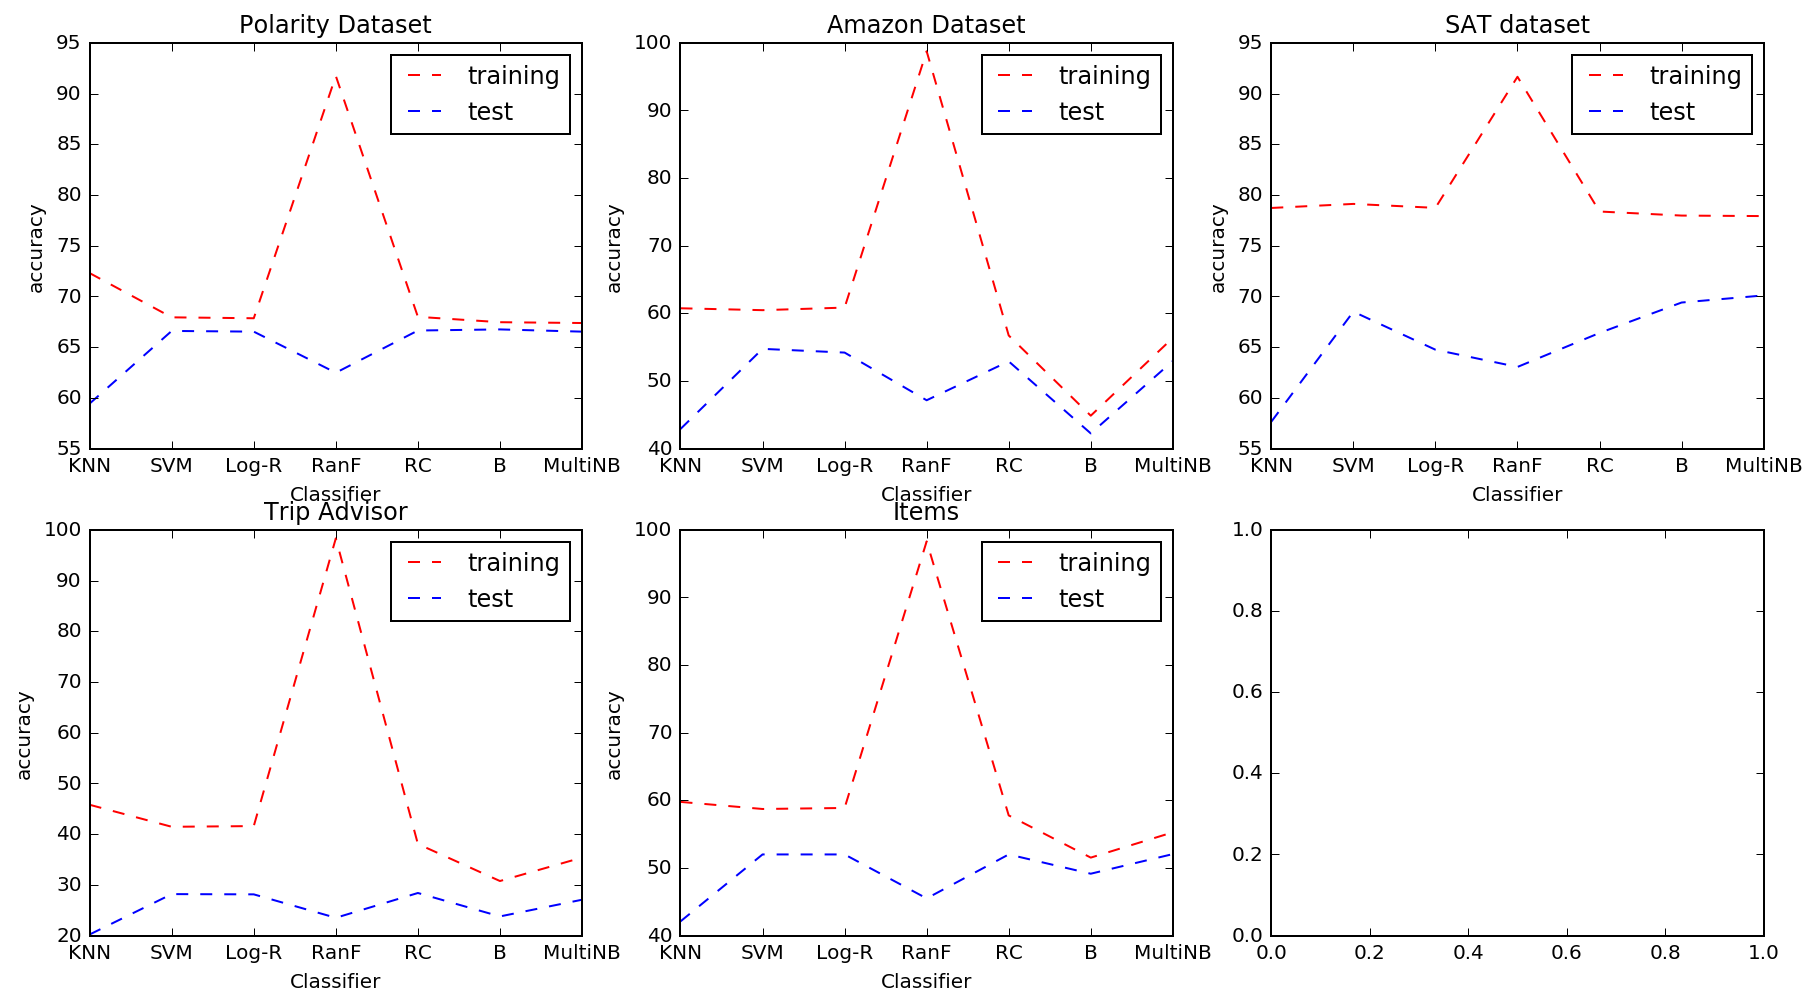

In [12]:
x =[0,1,2,3,4,5,6]
classifier = ['KNN','SVM','Log-R','RanF', 'RC','B','MultiNB']
Leg = ["training","test"]
n = 5
fig, axes = plt.subplots(2, 3, squeeze=True, figsize=(15, 8))
for i in range(n):
    axes[i//3,i%3].set_xticks(x)
    axes[i//3,i%3].set_xticklabels(classifier, fontdict=None, minor=False)
    axes[i//3,i%3].plot(x,train_accuracies[i],"r--",x,test_accuracies[i],"b--")
    axes[i//3,i%3].set_title(names[i])
    axes[i//3,i%3].set_ylabel("accuracy")
    axes[i//3,i%3].set_xlabel("Classifier")
    axes[i//3,i%3].legend(Leg)

for i in range(n):  
    display("Dataset: {} ".format(names[i]))
    value = max(test_accuracies[i])
    index = test_accuracies[i].index(value)
    display("best test accuracy = {}  for = {}".format(value,classifier[index]))
    
    
#plt.xticks(x,classifier)#,names,knn_test,"b--")
#plt.plot(x,train_accuracies[0],"r--",x,test_accuracies[0],"b--")



#plt.show()

# Incremental Learning 
Due to memory limitation we can't apply the classifier on the whole chunck of data at the same time.Therefore we use partial training of classifiers. However we separate the binary data (**SAT and polarity data**) and the ranking data (** Amazon and Review data**) for separate classifiers 

** Binary data **

In [64]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB

test_stats = {'n_test': 0, 'n_test_pos': 0}
def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats['t0']
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s


#Overall_data = [SAT_data,Amazon_data,polarity_data,review_data]
Overall_data = [Amazon_data,review_data]
batches = []
#Y_polarity = np.unique(np.asarray(column(SAT_data,0)))
#Y_tripAdvisor = np.unique(np.asarray(column(tripAdvisor_data,0)))
#Y_tripAdvisor = [abs(x) for x in Y_tripAdvisor]
Y_amazon = np.unique(np.asarray(column(Amazon_data,0)))
#Y_sat = np.unique(np.asarray(column(polarity_data,0)))
Y_items = np.unique(np.asarray(column(review_data,0)))
#y_all =np.unique(np.concatenate((Y_polarity,Y_amazon,Y_sat,Y_items),axis = 0))
y_all =np.unique(np.concatenate((Y_amazon,Y_items),axis = 0))
print(y_all)
minibatch_size = 10000

# divide data into batches
i = 0
while (i<len(Overall_data)):
    start = 0
    trans = False
    leftover_len = 0
    while not(trans):
        if not(leftover_len == 0):
            batch = np.concatenate ((leftover , Overall_data[i][start:start + minibatch_size - leftover_len]), axis = 0)
            batches.append(batch)
            start = start + minibatch_size - leftover_len
            leftover_len = 0
        elif not (start + minibatch_size >= len(Overall_data[i]) ):
            batch = Overall_data[i][start:start + minibatch_size]
            batches.append(batch)
            start = start + minibatch_size
        else: 
            leftover_len = len(Overall_data[i]) - start
            leftover = Overall_data[i][start:]
            trans = True
            start = 0
            
        
    i += 1

        
#Classifiers      
partial_fit_classifiers = {
    'SGD': SGDClassifier(),
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
}
        
                  
cls_stats = {}

for cls_name in partial_fit_classifiers:
    stats = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time(),
             'runtime_history': [(0, 0)], 'total_fit_time': 0.0}
    cls_stats[cls_name] = stats

number_minibatch = len(batches)
total_vect_time = 0.0
all_classes = np.array([0, 1 , 2, 3, 4 ,5])
    
print(number_minibatch)
# Main loop : iterate on mini-batches of examples
for i in range(number_minibatch):
    print("Batch number = {}".format(i))
    batch = batches[i]
    textset = column(batch,1)
    filtered=[]
    for item in textset:
        words = word_tokenize(item)
        words =[word.lower() for word in words]
        filtered_item=[];
        for w in words:
            if w not in stop_words:
                filtered_item.append(w)
        result = ' '.join(filtered_item)
        filtered.append(result)
    X, vocab = compute_bag_of_words(filtered, nwords)
    Y = column(batch,0)

    cutoff = math.ceil(len(Y)*0.75)
    X_train = X#[0:cutoff]
    X_test = X[cutoff:]
    y_train = Y#[0:cutoff]
    y_test = Y[cutoff:]
    test_stats['n_test'] += len(y_test)
    test_stats['n_test_pos'] += sum([int(x) for x in y_test])
    
    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        # update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=y_all)

        # accumulate test accuracy stats
        cls_stats[cls_name]['total_fit_time'] += time.time() - tick
        cls_stats[cls_name]['n_train'] += X_train.shape[0]
        cls_stats[cls_name]['n_train_pos'] += sum([int(x) for x in y_train])
        tick = time.time()

        cls_stats[cls_name]['accuracy'] = cls.score(X_test, y_test)
        cls_stats[cls_name]['prediction_time'] = time.time() - tick
        acc_history = (cls_stats[cls_name]['accuracy'],
                       cls_stats[cls_name]['n_train'])
        cls_stats[cls_name]['accuracy_history'].append(acc_history)
        run_history = (cls_stats[cls_name]['accuracy'],
                       total_vect_time + cls_stats[cls_name]['total_fit_time'])
        cls_stats[cls_name]['runtime_history'].append(run_history)

        #if i % 10 == 0:
        print(progress(cls_name, cls_stats[cls_name]))
    #if i % 3 == 10:
        print('\n')

['1' '2' '3' '4' '5']
3
Batch number = 0
                 SGD classifier : 	 10000 train docs ( 37200 positive)   2500 test docs (  9204 positive) accuracy: 0.487 in 25.27s (  395 docs/s)


  Passive-Aggressive classifier : 	 10000 train docs ( 37200 positive)   2500 test docs (  9204 positive) accuracy: 0.486 in 25.25s (  396 docs/s)


          Perceptron classifier : 	 10000 train docs ( 37200 positive)   2500 test docs (  9204 positive) accuracy: 0.485 in 25.27s (  395 docs/s)


      NB Multinomial classifier : 	 10000 train docs ( 37200 positive)   2500 test docs (  9204 positive) accuracy: 0.548 in 25.42s (  393 docs/s)


Batch number = 1
                 SGD classifier : 	 20000 train docs ( 75869 positive)   5000 test docs ( 19068 positive) accuracy: 0.494 in 41.83s (  478 docs/s)


  Passive-Aggressive classifier : 	 20000 train docs ( 75869 positive)   5000 test docs ( 19068 positive) accuracy: 0.508 in 41.82s (  478 docs/s)


          Perceptron classifier : 	 20000 train 

# Performance and Visualization of Incremental Learning classifier 

In [65]:
#Performance of the classifiers 
print("Accuracy of SGD is {}".format(cls_stats['SGD']['accuracy']) )
print("Accuracy of Perceptron is {}".format(cls_stats['Perceptron']['accuracy']) )
print("Accuracy of NB Multinomial is {}".format(cls_stats['NB Multinomial']['accuracy']) )
print("Accuracy of Passive-Aggressive is {}".format(cls_stats['Passive-Aggressive']['accuracy']) )



Accuracy of SGD is 0.5136
Accuracy of Perceptron is 0.522
Accuracy of NB Multinomial is 0.5364
Accuracy of Passive-Aggressive is 0.4268


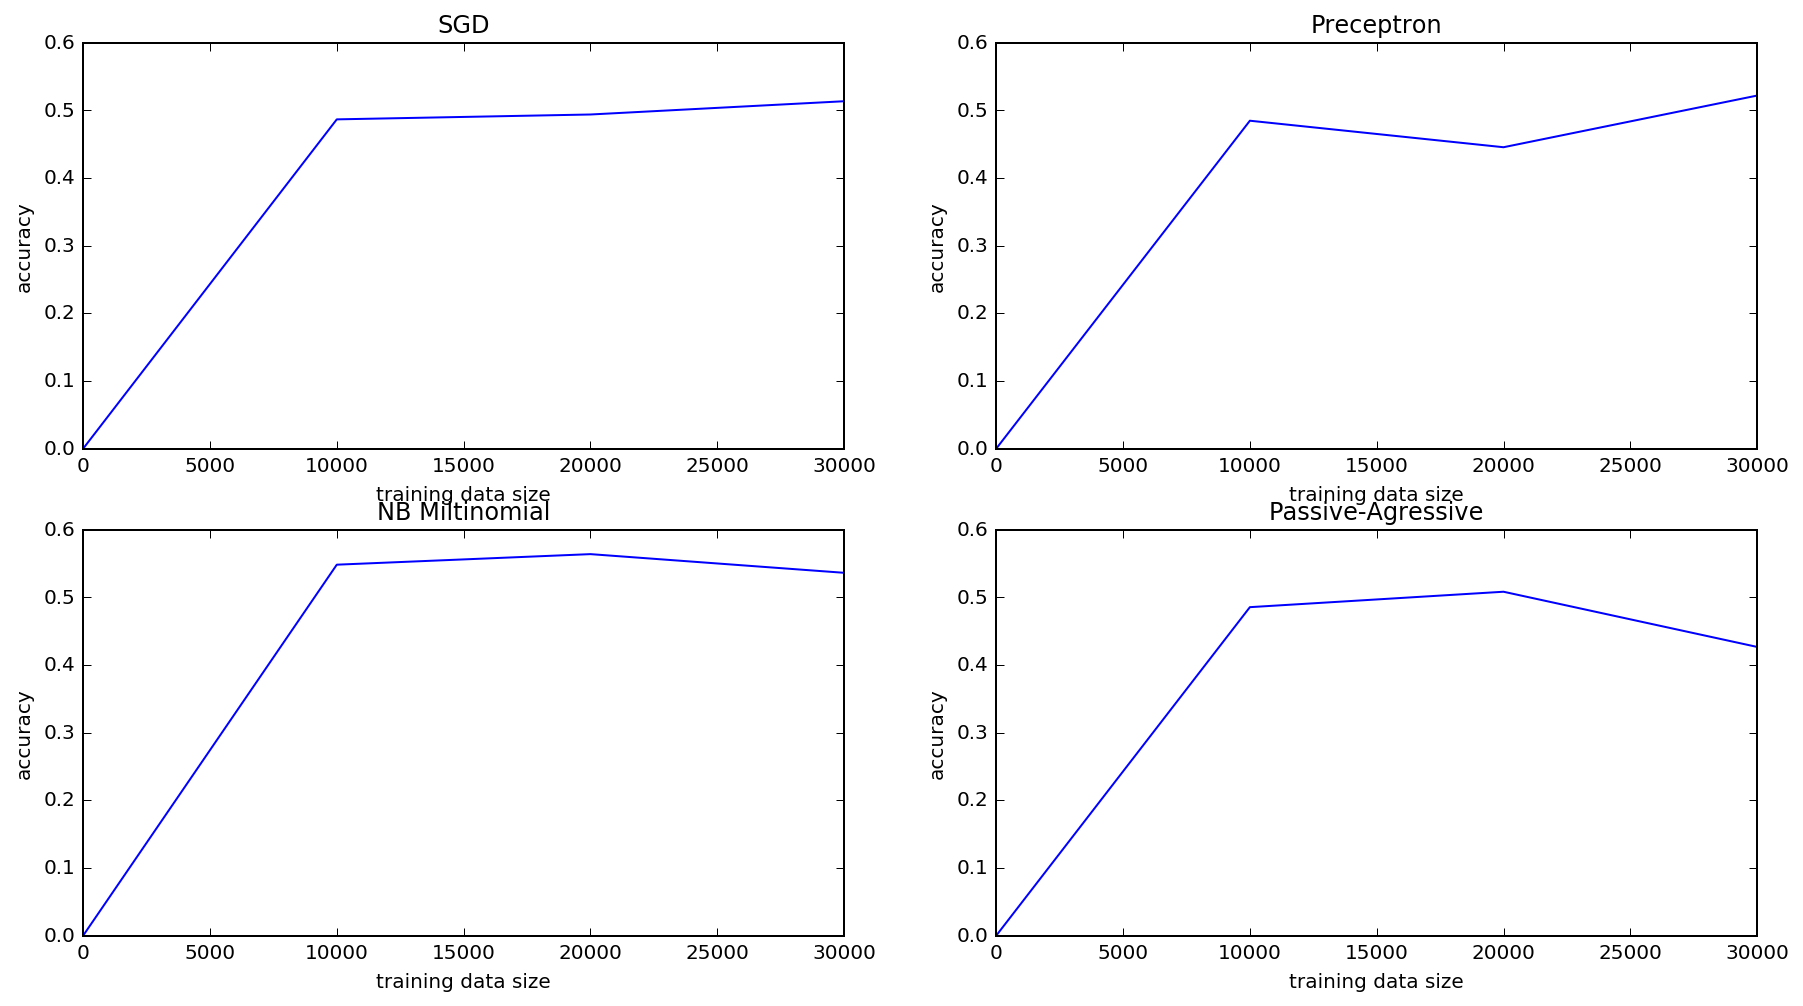

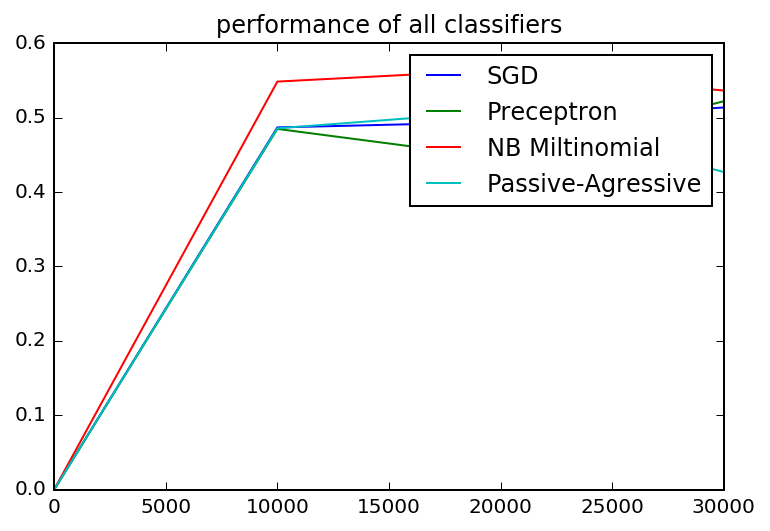

In [66]:
#Visualization of performance throughout learning process
accuracies_SGD = [x[0] for x in cls_stats['SGD']['accuracy_history']]
train_SGD = [x[1] for x in cls_stats['SGD']['accuracy_history']]
accuracies_Perceptron = [x[0] for x in cls_stats['Perceptron']['accuracy_history']]
train_Perceptron = [x[1] for x in cls_stats['Perceptron']['accuracy_history']]
accuracies_NBMultinomial = [x[0] for x in cls_stats['NB Multinomial']['accuracy_history']]
train_NBMultinomial = [x[1] for x in cls_stats['NB Multinomial']['accuracy_history']]
accuracies_Passive_Aggressive = [x[0] for x in cls_stats['Passive-Aggressive']['accuracy_history']]
train_Passive_Aggressive = [x[1] for x in cls_stats['Passive-Aggressive']['accuracy_history']]


titles = ["SGD","Preceptron", "NB Miltinomial", "Passive-Agressive"]
accuracies=[accuracies_SGD,accuracies_Perceptron,accuracies_NBMultinomial,accuracies_Passive_Aggressive]
train=[train_SGD,train_Perceptron,train_NBMultinomial,train_Passive_Aggressive]

n = 4
fig, axes = plt.subplots(2,2, squeeze=True, figsize=(15, 8))
for i in range(n):
    axes[i//2,i%2].plot(train[i],accuracies[i])
    axes[i//2,i%2].set_title(titles[i])
    axes[i//2,i%2].set_ylabel("accuracy")
    axes[i//2,i%2].set_xlabel("training data size")

plt.figure()
plt.plot(train_SGD,accuracies_SGD,train_Perceptron,accuracies_Perceptron, train_NBMultinomial,accuracies_NBMultinomial 
         ,train_Passive_Aggressive,accuracies_Passive_Aggressive)
plt.title("performance of all classifiers")
plt.legend(titles)
  

** Binary data **

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB

test_stats = {'n_test': 0, 'n_test_pos': 0}
def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats['t0']
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s


#Overall_data = [SAT_data,Amazon_data,polarity_data,review_data]
Overall_data = [SAT_data,polarity_data]
batches = []
Y_polarity = np.unique(np.asarray(column(SAT_data,0)))
#Y_amazon = np.unique(np.asarray(column(Amazon_data,0)))
Y_sat = np.unique(np.asarray(column(polarity_data,0)))
#Y_items = np.unique(np.asarray(column(review_data,0)))
#y_all =np.unique(np.concatenate((Y_polarity,Y_amazon,Y_sat,Y_items),axis = 0))
y_all =np.unique(np.concatenate((Y_polarity,Y_sat),axis = 0))
print(y_all)
minibatch_size = 10000

# divide data into batches
i = 0
while (i<len(Overall_data)):
    start = 0
    trans = False
    leftover_len = 0
    while not(trans):
        if not(leftover_len == 0):
            batch = np.concatenate ((leftover , Overall_data[i][start:start + minibatch_size - leftover_len]), axis = 0)
            batches.append(batch)
            start = start + minibatch_size - leftover_len
            leftover_len = 0
        elif not (start + minibatch_size >= len(Overall_data[i]) ):
            batch = Overall_data[i][start:start + minibatch_size]
            batches.append(batch)
            start = start + minibatch_size
        else: 
            leftover_len = len(Overall_data[i]) - start
            leftover = Overall_data[i][start:]
            trans = True
            start = 0
            
        
    i += 1

        
#Classifiers      
partial_fit_classifiers2 = {
    'SGD': SGDClassifier(),
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
}
        
                  
cls_stats2 = {}

for cls_name in partial_fit_classifiers2:
    stats2 = {'n_train': 0, 'n_train_pos': 0,
             'accuracy': 0.0, 'accuracy_history': [(0, 0)], 't0': time.time(),
             'runtime_history': [(0, 0)], 'total_fit_time': 0.0}
    cls_stats2[cls_name] = stats2

number_minibatch = len(batches)
total_vect_time = 0.0
    
print(number_minibatch)
# Main loop : iterate on mini-batches of examples
for i in range(number_minibatch):
    print("Batch number = {}".format(i))
    batch = batches[i]
    textset = column(batch,1)
    filtered=[]
    for item in textset:
        words = word_tokenize(item)
        words =[word.lower() for word in words]
        filtered_item=[];
        for w in words:
            if w not in stop_words:
                filtered_item.append(w)
        result = ' '.join(filtered_item)
        filtered.append(result)
    X, vocab = compute_bag_of_words(filtered, nwords)
    Y = column(batch,0)

    cutoff = math.ceil(len(Y)*0.75)
    X_train = X[0:cutoff]
    X_test = X[cutoff:]
    y_train = Y[0:cutoff]
    y_test = Y[cutoff:]
    test_stats['n_test'] += len(y_test)
    test_stats['n_test_pos'] += sum([int(x) for x in y_test])
    
    for cls_name, cls in partial_fit_classifiers2.items():
        tick = time.time()
        # update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=y_all)

        # accumulate test accuracy stats
        cls_stats2[cls_name]['total_fit_time'] += time.time() - tick
        cls_stats2[cls_name]['n_train'] += X_train.shape[0]
        cls_stats2[cls_name]['n_train_pos'] += sum([int(x) for x in y_train])
        tick = time.time()

        cls_stats2[cls_name]['accuracy'] = cls.score(X_test, y_test)
        cls_stats2[cls_name]['prediction_time'] = time.time() - tick
        acc_history = (cls_stats2[cls_name]['accuracy'],
                       cls_stats2[cls_name]['n_train'])
        cls_stats2[cls_name]['accuracy_history'].append(acc_history)
        run_history = (cls_stats2[cls_name]['accuracy'],
                       total_vect_time + cls_stats2[cls_name]['total_fit_time'])
        cls_stats2[cls_name]['runtime_history'].append(run_history)

        if i % 10 == 0:
            print(progress(cls_name, cls_stats2[cls_name]))
    if i % 3 == 10:
        print('\n')

['0' '5']
158
Batch number = 0
                 SGD classifier : 	  7500 train docs ( 13605 positive)   2500 test docs (  7340 positive) accuracy: 0.673 in 19.62s (  382 docs/s)
  Passive-Aggressive classifier : 	  7500 train docs ( 13605 positive)   2500 test docs (  7340 positive) accuracy: 0.606 in 19.45s (  385 docs/s)
          Perceptron classifier : 	  7500 train docs ( 13605 positive)   2500 test docs (  7340 positive) accuracy: 0.575 in 19.47s (  385 docs/s)
      NB Multinomial classifier : 	  7500 train docs ( 13605 positive)   2500 test docs (  7340 positive) accuracy: 0.704 in 19.55s (  383 docs/s)
Batch number = 1
Batch number = 2
Batch number = 3
Batch number = 4
Batch number = 5
Batch number = 6
Batch number = 7
Batch number = 8
Batch number = 9
Batch number = 10
                 SGD classifier : 	 82500 train docs (231400 positive)  27500 test docs ( 80880 positive) accuracy: 0.690 in 56.01s ( 1472 docs/s)
  Passive-Aggressive classifier : 	 82500 train docs (231400 po

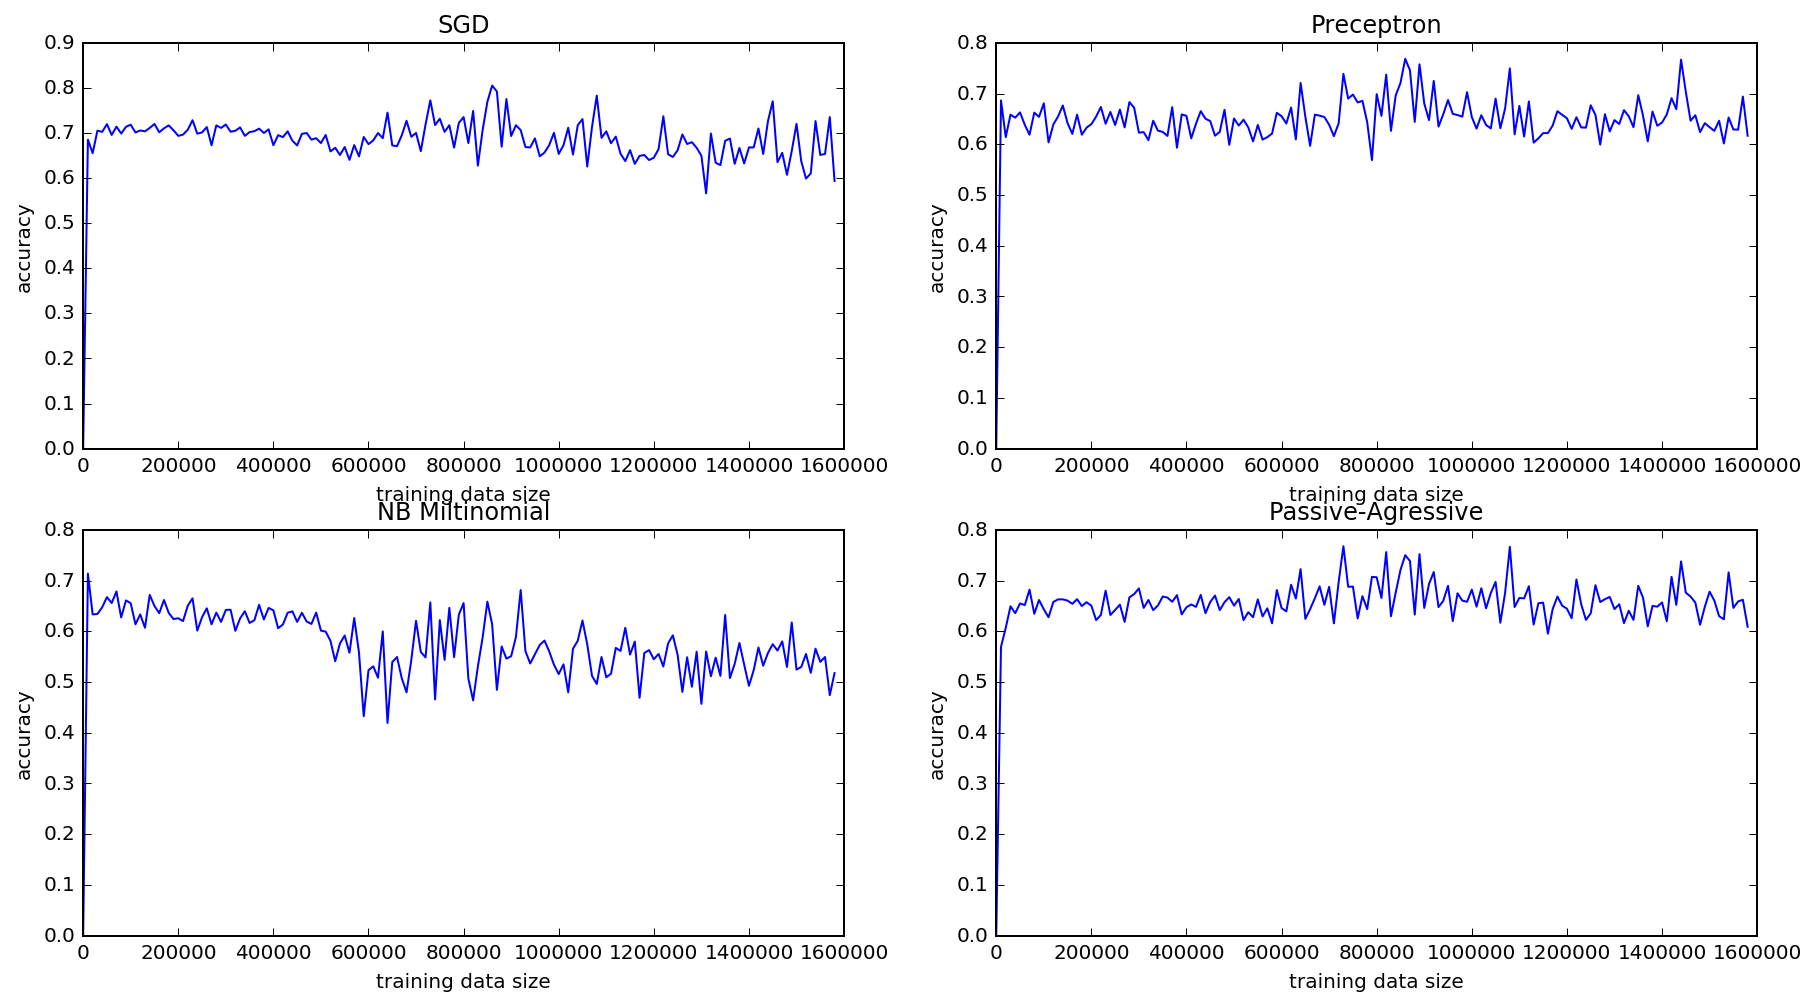

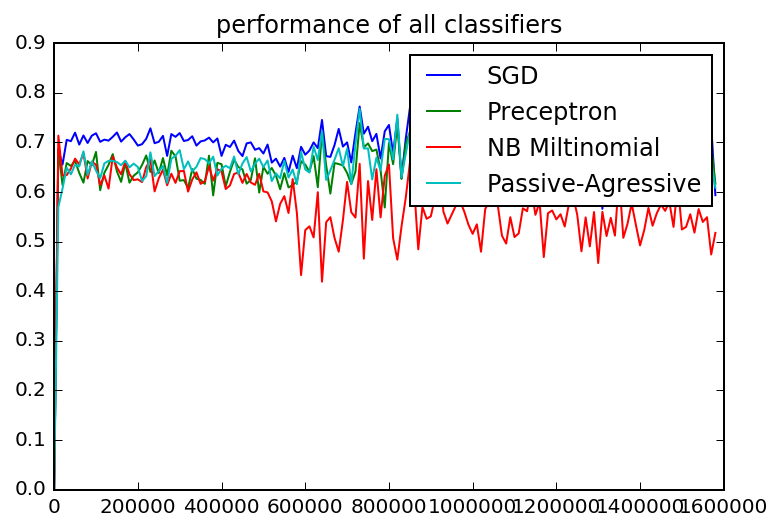

In [26]:
#Visualization of performance throughout learning process
accuracies_SGD = [x[0] for x in cls_stats2['SGD']['accuracy_history']]
train_SGD = [x[1] for x in cls_stats2['SGD']['accuracy_history']]
accuracies_Perceptron = [x[0] for x in cls_stats2['Perceptron']['accuracy_history']]
train_Perceptron = [x[1] for x in cls_stats2['Perceptron']['accuracy_history']]
accuracies_NBMultinomial = [x[0] for x in cls_stats2['NB Multinomial']['accuracy_history']]
train_NBMultinomial = [x[1] for x in cls_stats2['NB Multinomial']['accuracy_history']]
accuracies_Passive_Aggressive = [x[0] for x in cls_stats2['Passive-Aggressive']['accuracy_history']]
train_Passive_Aggressive = [x[1] for x in cls_stats2['Passive-Aggressive']['accuracy_history']]


titles = ["SGD","Preceptron", "NB Miltinomial", "Passive-Agressive"]
accuracies=[accuracies_SGD,accuracies_Perceptron,accuracies_NBMultinomial,accuracies_Passive_Aggressive]
train=[train_SGD,train_Perceptron,train_NBMultinomial,train_Passive_Aggressive]

n = 4
fig, axes = plt.subplots(2,2, squeeze=True, figsize=(15, 8))
for i in range(n):
    axes[i//2,i%2].plot(train[i],accuracies[i])
    axes[i//2,i%2].set_title(titles[i])
    axes[i//2,i%2].set_ylabel("accuracy")
    axes[i//2,i%2].set_xlabel("training data size")

plt.figure()
plt.plot(train_SGD,accuracies_SGD,train_Perceptron,accuracies_Perceptron, train_NBMultinomial,accuracies_NBMultinomial 
         ,train_Passive_Aggressive,accuracies_Passive_Aggressive)
plt.title("performance of all classifiers")
plt.legend(titles)